# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secd) Configurations and Paths 
- [D](#sece) Patient Interface and Train/Val/Test Partitioning


## Evaluations

- [1](#sec1) Snooping/Selecting Best Models from the Validation Set
- [2](#sec2) Predictive Performance: MIMIC-III (Test Set)
- [3](#sec3) Predictive Performance: MIMIC-IV (Test Set)
- [4](#sec4) Predictive Performance: from MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import display
from upsetplot import from_contents, plot, UpSet, from_indicators


<a name="secb"></a>

### B Internal Imports [^](#outline)

In [2]:
HOME = os.environ.get('HOME')

%load_ext autoreload
%autoreload 2

import analysis as A
import common as C



/home/asem/GP/env/icenode-env/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


<a name="secc"></a>

### C Configurations and Paths [^](#outline)

In [3]:
mimic_dir = {
    'M3': f'{HOME}/GP/ehr-data/mimic3-transforms',
    'M4': f'{HOME}/GP/ehr-data/mimic4-transforms'
}

train_dir = {
    'GM3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_G_M3',
    'M3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_M3',
    'M4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_M4',
    'GM4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_G_M4'
}

model_dir = {
    'ICE-NODE': 'icenode_2lr',
    'ICE-NODE_UNIFORM': 'icenode_uniform2lr',
    'GRU': 'gru',
    'RETAIN': 'retain',
    'LogReg': 'window_logreg'
}


clfs = list(model_dir.keys())

relative_auc_config = {
    'pvalue': 0.01, 
    'min_auc': 0.9
}
top_k_list=[5, 10, 15]
percentiles=20 
n_percentiles=int(100/percentiles)
plt.rcParams["font.family"] = "Loma"#, "serif"


In [4]:
output_dir = 'artefacts'
Path(output_dir).mkdir(parents=True, exist_ok=True)


<a name="secd"></a>

### D Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [5]:
m4_interface = C.create_patient_interface(mimic_dir['M4'])
m3_interface = C.create_patient_interface(mimic_dir['M3'])

m4_train_ids, m4_valid_ids, m4_test_ids = m4_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)
m3_train_ids, m3_valid_ids, m3_test_ids = m3_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)


In [6]:
m4_percentiles = m4_interface.dx_flatccs_by_percentiles(percentiles)
m3_percentiles = m3_interface.dx_flatccs_by_percentiles(percentiles)

m4_train_percentiles = m4_interface.dx_flatccs_by_percentiles(percentiles, m4_train_ids)
m3_train_percentiles = m3_interface.dx_flatccs_by_percentiles(percentiles, m3_train_ids)

<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [7]:
# Classifiers with Linear Embeddings
clfs = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU',
    'RETAIN',
    'LogReg'
)


# Classifiers with GRAM Embeddings
clfsG = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU'
)

In [ ]:
m4_traces = A.performance_traces(data_tag='M4', 
                                 clfs=clfs, 
                                 train_dir=train_dir, 
                                 model_dir=model_dir)
gm4_traces =  A.performance_traces(data_tag='GM4', 
                                   clfs=clfsG, 
                                   train_dir=train_dir, 
                                   model_dir=model_dir)

gm3_traces =  A.performance_traces(data_tag='GM3', 
                                   clfs=clfsG, 
                                   train_dir=train_dir, 
                                   model_dir=model_dir)
m3_traces = A.performance_traces(data_tag='M3', 
                                 clfs=clfs, 
                                 train_dir=train_dir, 
                                 model_dir=model_dir)

plt_ctx = lambda : sns.plotting_context("poster", font_scale=2, rc={"lines.linewidth": 2.5,  'grid.linestyle': '--'})


In [ ]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=m4_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()

    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/M4_performance_trace.pdf")

In [ ]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=m3_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/M3_performance_trace.pdf")

In [ ]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=gm3_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/GM3_performance_trace.pdf")

In [ ]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=gm4_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/GM4_performance_trace.pdf")

In [8]:
print('> Models trained on MIMIC-III')
m3_uAUC = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                               criterion='MICRO-AUC',  comp=max)
display(m3_uAUC['summary'])

print('> Models trained on MIMIC-IV')
m4_uAUC = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4', 
                               criterion='MICRO-AUC',  comp=max)
display(m4_uAUC['summary'])


print('> Models (GRAM) trained on MIMIC-III')
gm3_uAUC = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM3',  
                                criterion='MICRO-AUC', comp=max)
display(gm3_uAUC['summary'])

print('> Models (GRAM) trained on MIMIC-IV')
gm4_uAUC = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM4', 
                                criterion='MICRO-AUC', comp=max)
display(gm4_uAUC['summary'])


> Models trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,57,0.925790
1,ICE-NODE_UNIFORM,44,0.925757
2,GRU,32,0.923570
3,RETAIN,20,0.927307
4,LogReg,0,0.912001


> Models trained on MIMIC-IV


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,38,0.933961
1,ICE-NODE_UNIFORM,66,0.932462
2,GRU,15,0.936528
3,RETAIN,17,0.936482
4,LogReg,0,0.891420


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,58,0.924722
1,ICE-NODE_UNIFORM,58,0.924760
2,GRU,32,0.923149


> Models (GRAM) trained on MIMIC-IV


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,41,0.934028
1,ICE-NODE_UNIFORM,29,0.932499
2,GRU,17,0.936749


In [ ]:
print('> Models trained on MIMIC-III')
m3_loss =  A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                                criterion='loss', comp=min)
display(m3_loss['summary'])

print('> Models trained on MIMIC-IV')
m4_loss = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4',
                             criterion='loss',  comp=min)
display(m4_loss['summary'])

print('> Models (GRAM) trained on MIMIC-III')
gm3_loss = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM3',
                                criterion='loss', comp=min)
display(gm3_loss['summary'])

print('> Models (GRAM) trained on MIMIC-IV')
gm4_loss = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM4',
                                criterion='loss', comp=min)
display(gm4_loss['summary'])


In [9]:
def combine_acc(row):
    return 1 / (1 / row.loc[list(f'ACC-P{i}' for i in range(5))]).sum()

print('> Models trained on MIMIC-III')
m3_comb = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                             criterion=combine_acc, comp=max)
display(m3_comb['summary'])


print('> Models trained on MIMIC-IV')
m4_comb = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4', 
                             criterion=combine_acc, comp=max)
display(m4_comb['summary'])


print('> Models (GRAM) trained on MIMIC-III')
gm3_comb = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM3', 
                              criterion=combine_acc, comp=max)
display(gm3_comb['summary'])


print('> Models (GRAM) trained on MIMIC-IV')
gm4_comb = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM4', 
                               criterion=combine_acc, comp=max)
display(gm4_comb['summary'])



> Models trained on MIMIC-III


,Clf,Best_i,<function combine_acc at 0x7f49499a2040>
0,ICE-NODE,90,0.109711
1,ICE-NODE_UNIFORM,94,0.109345
2,GRU,39,0.107409
3,RETAIN,40,0.109896
4,LogReg,0,0.089477


> Models trained on MIMIC-IV


,Clf,Best_i,<function combine_acc at 0x7f49499a2040>
0,ICE-NODE,88,0.126702
1,ICE-NODE_UNIFORM,88,0.125716
2,GRU,19,0.127814
3,RETAIN,23,0.127869
4,LogReg,0,0.031255


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,<function combine_acc at 0x7f49499a2040>
0,ICE-NODE,88,0.107542
1,ICE-NODE_UNIFORM,90,0.107439
2,GRU,44,0.106158


> Models (GRAM) trained on MIMIC-IV


,Clf,Best_i,<function combine_acc at 0x7f49499a2040>
0,ICE-NODE,88,0.126651
1,ICE-NODE_UNIFORM,88,0.125798
2,GRU,27,0.127750


In [10]:

m3_models_uAUC = C.get_models(clfs, m3_uAUC["config"], m3_uAUC["params"], m3_interface)
gm3_models_uAUC = C.get_models(clfsG, gm3_uAUC["config"], gm3_uAUC["params"], m3_interface)

m4_models_uAUC = C.get_models(clfs, m4_uAUC["config"], m4_uAUC["params"], m4_interface)
gm4_models_uAUC = C.get_models(clfsG, gm4_uAUC["config"], gm4_uAUC["params"], m4_interface)


In [ ]:
m3_models_loss = C.get_models(clfs, m3_loss["config"], m3_loss["params"], m3_interface)
gm3_models_loss = C.get_models(clfsG, gm3_loss["config"], gm3_loss["params"], m3_interface)

m4_models_loss = C.get_models(clfs, m4_loss["config"], m4_loss["params"], m4_interface)
gm4_models_loss = C.get_models(clfsG, gm4_loss["config"], gm4_loss["params"], m4_interface)

In [11]:
m3_models_comb = C.get_models(clfs, m3_comb["config"], m3_comb["params"], m3_interface)
gm3_models_comb = C.get_models(clfsG, gm3_comb["config"], gm3_comb["params"], m3_interface)

m4_models_comb = C.get_models(clfs, m4_comb["config"], m4_comb["params"], m4_interface)
gm4_models_comb = C.get_models(clfsG, gm4_comb["config"], gm4_comb["params"], m4_interface)

### Snooping on MIMIC-III Validation Set

In [ ]:
m3_val_res_uAUC = {clf: C.eval_(model, m3_valid_ids) for clf, model in m3_models_uAUC.items()} 
m3_val_res_comb = {clf: C.eval_(model, m3_valid_ids) for clf, model in m3_models_comb.items()} 
m3_val_res_loss = {clf: C.eval_(model, m3_valid_ids) for clf, model in m3_models_loss.items()} 

m3_val_res_all = {
    **{f'{clf}_uAUC': res for clf, res in m3_val_res_uAUC.items()},
    **{f'{clf}_comb': res for clf, res in m3_val_res_comb.items()},
    **{f'{clf}_loss': res for clf, res in m3_val_res_loss.items()}
}

In [ ]:
m3_val_auctests_all = A.codes_auc_pairwise_tests(m3_val_res_all, fast=True)

In [ ]:

selected_clfs = tuple(sorted(m3_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = A.relative_performance_upset(m3_val_auctests_all, selected_clfs, 
                                                                                              **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)

upset_object.plot()
plt.show()

### Snooping on MIMIC-IV Validation Set

In [ ]:
m4_val_res_uAUC = {clf: C.eval_(model, m4_valid_ids) for clf, model in m4_models_uAUC.items()} 
m4_val_res_comb = {clf: C.eval_(model, m4_valid_ids) for clf, model in m4_models_comb.items()} 
m4_val_res_loss = {clf: C.eval_(model, m4_valid_ids) for clf, model in m4_models_loss.items()} 

m4_val_res_all = {
    **{f'{clf}_uAUC': res for clf, res in m4_val_res_uAUC.items()},
    **{f'{clf}_comb': res for clf, res in m4_val_res_comb.items()},
    **{f'{clf}_loss': res for clf, res in m4_val_res_loss.items()}
}

In [ ]:
m4_val_auctests_all = A.codes_auc_pairwise_tests(m4_val_res_all, fast=True)

In [ ]:
selected_clfs = tuple(sorted(m4_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = A.relative_performance_upset(m4_val_auctests_all,
                                                                                              selected_clfs, 
                                                                                              **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)

upset_object.plot()
plt.show()

### Snooping Conclusion

In the cells above, we evaluate the model competency by the number of codes
predicted competently compared to the other models.
It is realized that for `GRU`, `RETAIN`, and `ICENODE_UNIFORM`, the competency is maximized by picking the
model with minimum validation loss throughout the training iterations.
However, `ICENODE` competency is maximized by picking the model with maximum average validation AUC throughout the training iterations. Therefore, subsequent evaluations will consider only the most competent models on the validation set, as we select in the next cell.

In [12]:
m4_models = {}
m3_models = {}
gm4_models = {}
gm3_models = {}

selection_dicts = (m4_models, 
                   m3_models, 
                   gm4_models,
                   gm3_models)

uAUC_dicts = (m4_uAUC,
              m3_uAUC,
              gm4_uAUC,
              gm3_uAUC)

comb_dicts = (m4_comb,
              m3_comb,
              gm4_comb,
              gm3_comb)


# loss_dicts = (m4_loss,
#               m3_loss,
#               gm4_loss,
#               gm3_loss)

for dict_a, dict_b in zip(selection_dicts, uAUC_dicts):
    for k in dict_b.keys():
        dict_a[k] = dict_b[k]


In [13]:
def cross_predictor(clf, source_tag, target_tag):
    if '/G' in clf:
        clf = clf.replace('/G', '')
        _params = {'M3': gm3_models['params'][clf], 
                   'M4': gm4_models['params'][clf]}
        _config = {'M3': gm3_models['config'][clf], 
                   'M4': gm4_models['config'][clf]}
    else:
        _params = {'M3': m3_models['params'][clf], 
                   'M4': m4_models['params'][clf]}
        _config = {'M3': m3_models['config'][clf], 
                   'M4': m3_models['config'][clf]}
    _interface = {'M3': m3_interface, 'M4': m4_interface}

    return C.get_model(clf=clf, 
                       config=_config[source_tag], 
                       params=_params[source_tag],
                       interface = _interface[target_tag])


<a name="sec2"></a>

## 2 Predictive Performance on MIMIC-III (Test Set) [^](#outline)

In [14]:
m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
            'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

m3_predictors = {clf: cross_predictor(clf, 'M3', 'M3') for clf in m3_clfs}

In [15]:
test_res_m3 = {clf: C.eval2_(model, m3_test_ids) for clf, model in m3_predictors.items()} 

In [16]:
auctests_m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m3.items()}, fast=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:16<00:00, 14.73it/s]


In [19]:
test_cols = [col for col in auctests_m3.columns if col[:2] == 'P0']
auctests_m3.loc[:, test_cols].isnull().max(axis=1).sum()

3

28 codes predicted an AUC higher than 0.9 by at least one model.
25 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


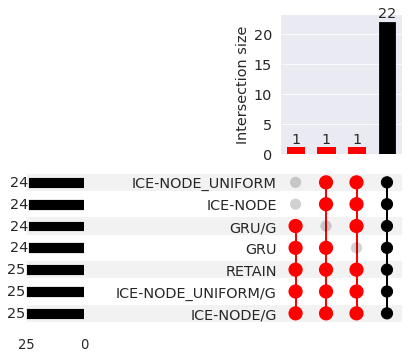

In [41]:

upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', #'LogReg', 
              'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']
upsetcontents_m3, upsetindicator_m3, data_m3,  _, compete_codesm3 = A.relative_performance_upset(auctests_m3, 
                                                                                               upset_clfs, 
                                                                                               **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(upsetindicator_m3, data=data_m3)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(max_subset_size=1,
                               facecolor="red",
                               edgecolor="red", linewidth=3)
    g = upset_object.plot()
    current_figure = plt.gcf()
    w, h = 3.5, 3
    wi, hi = current_figure.get_size_inches()
    current_figure.set_size_inches(hi*(w/h), hi)
    current_figure.savefig(f"upset_M3.pdf", bbox_inches='tight')

In [64]:
results_m3_eval,_ = A.evaluation_table(test_res_m3, m3_train_percentiles, top_k_list=top_k_list)

In [87]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G'
              )
results_m3_tables = A.top_k_tables(table_clfs, results_m3_eval, top_k_list=top_k_list,
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M3')

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
LogReg,0.103,0.263,0.248,0.322,0.437
RETAIN,0.109,0.225,0.282,0.320,0.584
GRU,0.116,0.215,0.244,0.346,0.556
GRU/G,0.107,0.217,0.251,0.350,0.571
ICE-NODE,0.104,0.226,0.268,0.337,0.601
ICE-NODE/G,0.102,0.219,0.262,0.339,0.604
ICE-NODE_UNIFORM,0.102,0.221,0.259,0.345,0.608
ICE-NODE_UNIFORM/G,0.103,0.221,0.263,0.338,0.603


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{LogReg} & 0.103 & \color{white} {\cellcolor{darkblue}} 0.263 & 0.248 & 0.322 & 0.437 \\
\texttt{RETAIN} & 0.109 & 0.225 & \color{white} {\cellcolor{darkblue}} 0.282 & 0.320 & 0.584 \\
\texttt{GRU} & \color{white} {\cellcolor{darkblue}} 0.116 & 0.215 & 0.244 & 0.346 & 0.556 \\
\texttt{GRU/G} & 0.107 & 0.217 & 0.251 & \color{white} {\cellcolor{darkblue}} 0.350 & 0.571 \\
\texttt{ICE-NODE} & 0.104 & 0.226 & 0.268 & 0.337 & 0.601 \\
\texttt{ICE-NODE/G} & 0.102 & 0.219 & 0.262 & 0.339 & 0.604 \\
\texttt{ICE-NODE\_UNIFORM} & 0.102 & 0.221 & 0.259 & 0.345 & \color{white} {\cellcolor{darkblue}} 0.608 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.103 & 0.221 & 0.263 & 0.338 & 0.603 \\
\end{tabular}



,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
LogReg,0.141,0.385,0.419,0.500,0.661
RETAIN,0.168,0.336,0.444,0.607,0.823
GRU,0.165,0.317,0.423,0.613,0.789
GRU/G,0.156,0.326,0.422,0.620,0.805
ICE-NODE,0.175,0.342,0.442,0.627,0.811
ICE-NODE/G,0.159,0.334,0.436,0.618,0.813
ICE-NODE_UNIFORM,0.166,0.341,0.432,0.633,0.818
ICE-NODE_UNIFORM/G,0.161,0.333,0.432,0.618,0.812


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{LogReg} & 0.141 & \color{white} {\cellcolor{darkblue}} 0.385 & 0.419 & 0.500 & 0.661 \\
\texttt{RETAIN} & 0.168 & 0.336 & \color{white} {\cellcolor{darkblue}} 0.444 & 0.607 & \color{white} {\cellcolor{darkblue}} 0.823 \\
\texttt{GRU} & 0.165 & 0.317 & 0.423 & 0.613 & 0.789 \\
\texttt{GRU/G} & 0.156 & 0.326 & 0.422 & 0.620 & 0.805 \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.175 & 0.342 & 0.442 & 0.627 & 0.811 \\
\texttt{ICE-NODE/G} & 0.159 & 0.334 & 0.436 & 0.618 & 0.813 \\
\texttt{ICE-NODE\_UNIFORM} & 0.166 & 0.341 & 0.432 & \color{white} {\cellcolor{darkblue}} 0.633 & 0.818 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.161 & 0.333 & 0.432 & 0.618 & 0.812 \\
\end{tabular}



,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
LogReg,0.164,0.454,0.543,0.683,0.777
RETAIN,0.208,0.415,0.579,0.778,0.926
GRU,0.214,0.400,0.556,0.768,0.900
GRU/G,0.204,0.403,0.546,0.778,0.906
ICE-NODE,0.220,0.425,0.578,0.782,0.902
ICE-NODE/G,0.205,0.421,0.569,0.782,0.907
ICE-NODE_UNIFORM,0.211,0.422,0.566,0.786,0.909
ICE-NODE_UNIFORM/G,0.206,0.419,0.565,0.782,0.907


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{LogReg} & 0.164 & \color{white} {\cellcolor{darkblue}} 0.454 & 0.543 & 0.683 & 0.777 \\
\texttt{RETAIN} & 0.208 & 0.415 & \color{white} {\cellcolor{darkblue}} 0.579 & 0.778 & \color{white} {\cellcolor{darkblue}} 0.926 \\
\texttt{GRU} & 0.214 & 0.400 & 0.556 & 0.768 & 0.900 \\
\texttt{GRU/G} & 0.204 & 0.403 & 0.546 & 0.778 & 0.906 \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.220 & 0.425 & 0.578 & 0.782 & 0.902 \\
\texttt{ICE-NODE/G} & 0.205 & 0.421 & 0.569 & 0.782 & 0.907 \\
\texttt{ICE-NODE\_UNIFORM} & 0.211 & 0.422 & 0.566 & \color{white} {\cellcolor{darkblue}} 0.786 & 0.909 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.206 & 0.419 & 0.565 & 0.782 & 0.907 \\
\end{tabular}



In [25]:
competing_tests_df = auctests_m3[auctests_m3.CODE_INDEX.isin(upsetindicator_m3[upsetindicator_m3.sum(axis=1)<7].index)]
competing_tests_df.loc[:, [col for col in competing_tests_df.columns if col[:2]=='P0']]

,P0(AUC_GRU==AUC_GRU/G),P0(AUC_GRU==AUC_ICE-NODE),P0(AUC_GRU==AUC_ICE-NODE/G),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM/G),P0(AUC_GRU==AUC_LogReg),P0(AUC_GRU==AUC_RETAIN),P0(AUC_GRU/G==AUC_ICE-NODE),P0(AUC_GRU/G==AUC_ICE-NODE/G),P0(AUC_GRU/G==AUC_ICE-NODE_UNIFORM),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN)
3,0.077,0.830,0.740,7.492e-01,0.555,0.022,0.904,2.200e-01,0.509,1.743e-01,...,0.148,0.009,0.015,0.845,0.038,0.054,0.710,0.009,0.675,0.031
27,0.686,0.002,0.048,1.620e-11,0.089,0.027,0.028,5.214e-06,0.013,4.930e-29,...,0.123,0.049,0.883,0.190,0.100,0.629,0.319,0.822,0.031,0.996


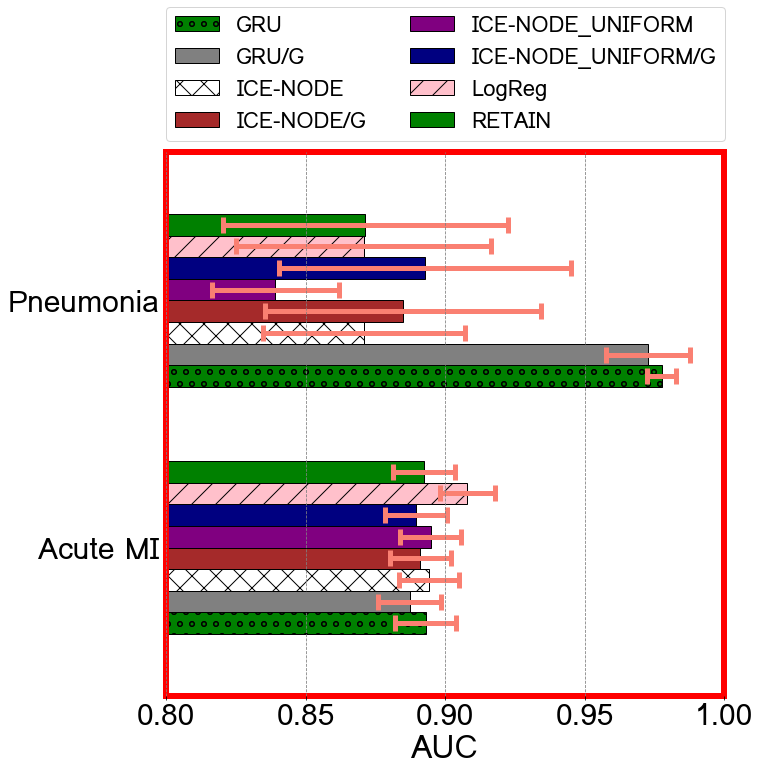

In [26]:
upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
              'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']

ax = A.selected_auc_barplot(upset_clfs, competing_tests_df,  horizontal=True)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig("icenode_m3.pdf", bbox_inches='tight')
plt.show()


<a name="sec3"></a>

## 3 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [17]:
m4_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in m4_clfs}

In [18]:
test_res_m4 = {clf: C.eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

In [19]:
auctests_m4 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4.items()}, fast=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [08:23<00:00,  2.08s/it]


85 codes predicted an AUC higher than 0.9 by at least one model.
84 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


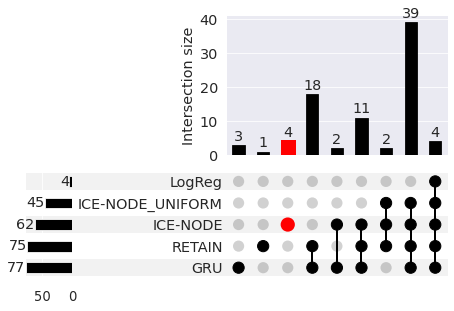

In [42]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

upsetcontents_m4, upsetindicator_m4, data_m4,  _, compete_codesm4 = A.relative_performance_upset(auctests_m4, 
                                                                                               upset_clfs, 
                                                                                               **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper",  font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(upsetindicator_m4, data=data_m4)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(present=['ICE-NODE'], absent=('ICE-NODE_UNIFORM', 'GRU', 'RETAIN'),
                               edgecolor="red", linewidth=3, facecolor="red")
    g = upset_object.plot()
    current_figure = plt.gcf()
#     w, h = 5, 3
#     wi, hi = current_figure.get_size_inches()
#     current_figure.set_size_inches(hi*(w/h), hi)

    current_figure.savefig(f"upset_M4.pdf", bbox_inches='tight')

In [66]:
results_m4_eval, _ = A.evaluation_table(test_res_m4, m4_train_percentiles, top_k_list=top_k_list)

In [86]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G'
              )
results_m4_tables = A.top_k_tables(table_clfs, results_m4_eval, top_k_list=top_k_list, 
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4')

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
LogReg,0.001,0.101,0.239,0.469,0.724
RETAIN,0.217,0.288,0.292,0.378,0.643
GRU,0.208,0.283,0.302,0.387,0.642
GRU/G,0.207,0.281,0.300,0.388,0.649
ICE-NODE,0.227,0.289,0.282,0.367,0.627
ICE-NODE/G,0.225,0.286,0.279,0.370,0.634
ICE-NODE_UNIFORM,0.231,0.286,0.277,0.369,0.621
ICE-NODE_UNIFORM/G,0.223,0.289,0.272,0.373,0.624


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{LogReg} & 0.001 & 0.101 & 0.239 & \color{white} {\cellcolor{darkblue}} 0.469 & \color{white} {\cellcolor{darkblue}} 0.724 \\
\texttt{RETAIN} & 0.217 & 0.288 & 0.292 & 0.378 & 0.643 \\
\texttt{GRU} & 0.208 & 0.283 & \color{white} {\cellcolor{darkblue}} 0.302 & 0.387 & 0.642 \\
\texttt{GRU/G} & 0.207 & 0.281 & 0.300 & 0.388 & 0.649 \\
\texttt{ICE-NODE} & 0.227 & \color{white} {\cellcolor{darkblue}} 0.289 & 0.282 & 0.367 & 0.627 \\
\texttt{ICE-NODE/G} & 0.225 & 0.286 & 0.279 & 0.370 & 0.634 \\
\texttt{ICE-NODE\_UNIFORM} & \color{white} {\cellcolor{darkblue}} 0.231 & 0.286 & 0.277 & 0.369 & 0.621 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.223 & \color{white} {\cellcolor{darkblue}} 0.289 & 0.272 & 0.373 & 0.624 \\
\end{tabular}



,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
LogReg,0.008,0.223,0.444,0.737,0.882
RETAIN,0.312,0.409,0.491,0.640,0.856
GRU,0.300,0.411,0.500,0.652,0.849
GRU/G,0.303,0.410,0.497,0.651,0.857
ICE-NODE,0.327,0.421,0.478,0.615,0.832
ICE-NODE/G,0.326,0.421,0.474,0.614,0.835
ICE-NODE_UNIFORM,0.328,0.417,0.471,0.612,0.828
ICE-NODE_UNIFORM/G,0.321,0.416,0.467,0.616,0.828


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{LogReg} & 0.008 & 0.223 & 0.444 & \color{white} {\cellcolor{darkblue}} 0.737 & \color{white} {\cellcolor{darkblue}} 0.882 \\
\texttt{RETAIN} & 0.312 & 0.409 & 0.491 & 0.640 & 0.856 \\
\texttt{GRU} & 0.300 & 0.411 & \color{white} {\cellcolor{darkblue}} 0.500 & 0.652 & 0.849 \\
\texttt{GRU/G} & 0.303 & 0.410 & 0.497 & 0.651 & 0.857 \\
\texttt{ICE-NODE} & 0.327 & \color{white} {\cellcolor{darkblue}} 0.421 & 0.478 & 0.615 & 0.832 \\
\texttt{ICE-NODE/G} & 0.326 & \color{white} {\cellcolor{darkblue}} 0.421 & 0.474 & 0.614 & 0.835 \\
\texttt{ICE-NODE\_UNIFORM} & \color{white} {\cellcolor{darkblue}} 0.328 & 0.417 & 0.471 & 0.612 & 0.828 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.321 & 0.416 & 0.467 & 0.616 & 0.828 \\
\end{tabular}



,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
LogReg,0.019,0.347,0.606,0.869,0.943
RETAIN,0.362,0.483,0.621,0.806,0.928
GRU,0.355,0.491,0.633,0.808,0.917
GRU/G,0.357,0.491,0.628,0.809,0.921
ICE-NODE,0.375,0.493,0.605,0.774,0.904
ICE-NODE/G,0.374,0.491,0.601,0.776,0.906
ICE-NODE_UNIFORM,0.376,0.486,0.598,0.773,0.904
ICE-NODE_UNIFORM/G,0.370,0.485,0.593,0.779,0.903


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{LogReg} & 0.019 & 0.347 & 0.606 & \color{white} {\cellcolor{darkblue}} 0.869 & \color{white} {\cellcolor{darkblue}} 0.943 \\
\texttt{RETAIN} & 0.362 & 0.483 & 0.621 & 0.806 & 0.928 \\
\texttt{GRU} & 0.355 & 0.491 & \color{white} {\cellcolor{darkblue}} 0.633 & 0.808 & 0.917 \\
\texttt{GRU/G} & 0.357 & 0.491 & 0.628 & 0.809 & 0.921 \\
\texttt{ICE-NODE} & 0.375 & \color{white} {\cellcolor{darkblue}} 0.493 & 0.605 & 0.774 & 0.904 \\
\texttt{ICE-NODE/G} & 0.374 & 0.491 & 0.601 & 0.776 & 0.906 \\
\texttt{ICE-NODE\_UNIFORM} & \color{white} {\cellcolor{darkblue}} 0.376 & 0.486 & 0.598 & 0.773 & 0.904 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.370 & 0.485 & 0.593 & 0.779 & 0.903 \\
\end{tabular}



In [77]:
icenode_m4_excl = upsetcontents_m4['ICE-NODE'] - set.union(*list(upsetcontents_m4[clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4_excl = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(GRU/G),AUC(ICE-NODE),AUC(ICE-NODE/G),AUC(ICE-NODE_UNIFORM),AUC(ICE-NODE_UNIFORM/G),AUC(LogReg),AUC(RETAIN),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN),DESC
6,6,2063.0,0.899,0.901,0.917,0.915,0.892,0.892,0.892,0.899,...,5.134e-24,9.131e-15,2.729e-09,0.794,9.974e-01,8.068e-05,9.344e-01,9.193e-05,7.969e-05,Pulm hart dx
94,94,129.0,0.959,0.960,0.969,0.971,0.960,0.959,0.926,0.961,...,7.252e-05,8.035e-11,2.701e-03,0.446,2.419e-07,4.685e-01,4.620e-07,2.815e-01,3.944e-09,Early labor
105,105,1040.0,0.981,0.981,0.984,0.985,0.979,0.979,0.970,0.980,...,2.064e-12,1.412e-25,9.216e-11,0.370,3.887e-09,2.257e-01,4.003e-10,3.306e-01,1.512e-15,Forceps del
236,236,8394.0,0.888,0.881,0.912,0.913,0.886,0.885,0.870,0.890,...,1.172e-92,3.731e-99,2.282e-45,0.026,1.358e-17,1.826e-03,4.539e-16,1.793e-04,3.536e-36,Other ear dx


In [35]:
# icenode_ratain_gru_m4 = upsetcontents_m4['ICE-NODE']
# icenode_ratain_gru_m4 = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_ratain_gru_m4)]
# icenode_ratain_gru_m4.sort_values('AUC(ICE-NODE)', ascending=False)[['CODE_INDEX', 'N_POSITIVE_CODES', 'DESC', 'AUC(ICE-NODE)']]

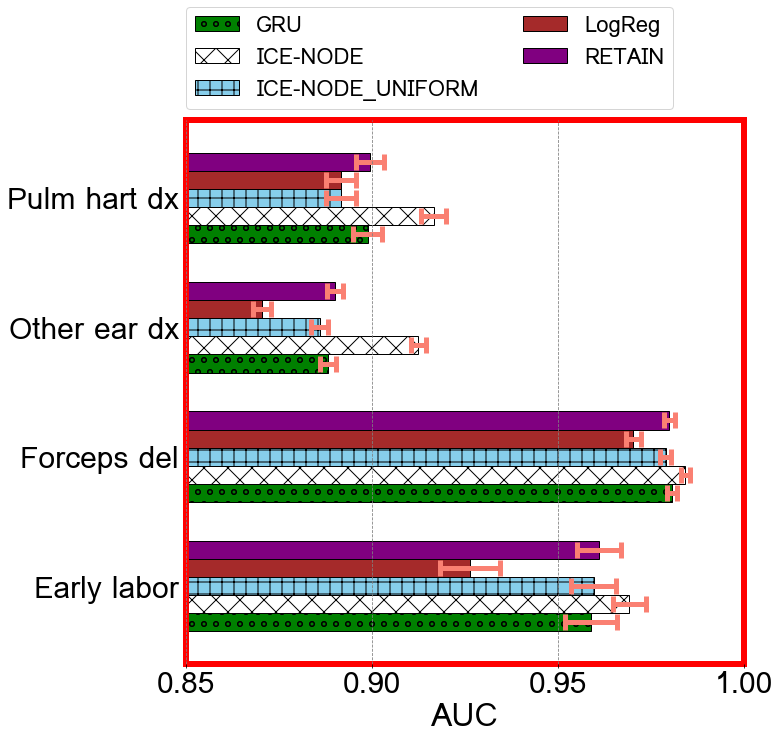

In [79]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg')
w, h = 4, 3
ax = A.selected_auc_barplot(upset_clfs, icenode_m4_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig("icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec4"></a>

## 4 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [20]:
m4m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface.subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in m4m3_clfs}

In [21]:
test_res_m4m3 = {clf: C.eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

In [22]:
auctests_m4m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4m3.items()}, fast=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:50<00:00,  2.20it/s]


53 codes predicted an AUC higher than 0.9 by at least one model.
50 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


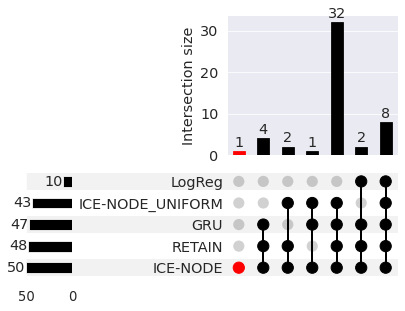

In [43]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

upsetcontents_m4m3, upsetindicator_m4m3, data_m4m3,  _, compete_codesm4m3 = A.relative_performance_upset(auctests_m4m3, 
                                                                                                       upset_clfs, 
                                                                                                       **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(upsetindicator_m4m3, data=data_m4m3)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(present='ICE-NODE', absent=['ICE-NODE_UNIFORM', 'GRU', 'RETAIN'],
                              edgecolor="red", facecolor="red")
    g = upset_object.plot()
    current_figure = plt.gcf()
    current_figure.savefig(f"upset_M4M3.pdf", bbox_inches='tight')

In [68]:

results_m4m3_eval, _ = A.evaluation_table(test_res_m4m3, m4_train_percentiles, top_k_list=top_k_list)

In [85]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G'
              )

results_m4m3_tables = A.top_k_tables(table_clfs, results_m4m3_eval, top_k_list=top_k_list, 
                                     n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4M3')

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
LogReg,0.003,0.061,0.193,0.481,0.718
RETAIN,0.214,0.210,0.291,0.395,0.593
GRU,0.200,0.199,0.296,0.405,0.609
GRU/G,0.197,0.198,0.292,0.408,0.608
ICE-NODE,0.216,0.203,0.275,0.391,0.596
ICE-NODE/G,0.214,0.202,0.275,0.390,0.601
ICE-NODE_UNIFORM,0.221,0.204,0.273,0.393,0.593
ICE-NODE_UNIFORM/G,0.210,0.206,0.268,0.398,0.598


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{LogReg} & 0.003 & 0.061 & 0.193 & \color{white} {\cellcolor{darkblue}} 0.481 & \color{white} {\cellcolor{darkblue}} 0.718 \\
\texttt{RETAIN} & 0.214 & \color{white} {\cellcolor{darkblue}} 0.210 & 0.291 & 0.395 & 0.593 \\
\texttt{GRU} & 0.200 & 0.199 & \color{white} {\cellcolor{darkblue}} 0.296 & 0.405 & 0.609 \\
\texttt{GRU/G} & 0.197 & 0.198 & 0.292 & 0.408 & 0.608 \\
\texttt{ICE-NODE} & 0.216 & 0.203 & 0.275 & 0.391 & 0.596 \\
\texttt{ICE-NODE/G} & 0.214 & 0.202 & 0.275 & 0.390 & 0.601 \\
\texttt{ICE-NODE\_UNIFORM} & \color{white} {\cellcolor{darkblue}} 0.221 & 0.204 & 0.273 & 0.393 & 0.593 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.210 & 0.206 & 0.268 & 0.398 & 0.598 \\
\end{tabular}



,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
LogReg,0.014,0.152,0.384,0.744,0.866
RETAIN,0.301,0.314,0.474,0.647,0.820
GRU,0.282,0.310,0.475,0.672,0.818
GRU/G,0.286,0.309,0.470,0.664,0.825
ICE-NODE,0.311,0.316,0.459,0.627,0.811
ICE-NODE/G,0.311,0.317,0.455,0.625,0.817
ICE-NODE_UNIFORM,0.316,0.320,0.453,0.626,0.807
ICE-NODE_UNIFORM/G,0.306,0.316,0.451,0.632,0.811


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{LogReg} & 0.014 & 0.152 & 0.384 & \color{white} {\cellcolor{darkblue}} 0.744 & \color{white} {\cellcolor{darkblue}} 0.866 \\
\texttt{RETAIN} & 0.301 & 0.314 & 0.474 & 0.647 & 0.820 \\
\texttt{GRU} & 0.282 & 0.310 & \color{white} {\cellcolor{darkblue}} 0.475 & 0.672 & 0.818 \\
\texttt{GRU/G} & 0.286 & 0.309 & 0.470 & 0.664 & 0.825 \\
\texttt{ICE-NODE} & 0.311 & 0.316 & 0.459 & 0.627 & 0.811 \\
\texttt{ICE-NODE/G} & 0.311 & 0.317 & 0.455 & 0.625 & 0.817 \\
\texttt{ICE-NODE\_UNIFORM} & \color{white} {\cellcolor{darkblue}} 0.316 & \color{white} {\cellcolor{darkblue}} 0.320 & 0.453 & 0.626 & 0.807 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.306 & 0.316 & 0.451 & 0.632 & 0.811 \\
\end{tabular}



,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
LogReg,0.027,0.240,0.543,0.858,0.939
RETAIN,0.351,0.385,0.602,0.805,0.905
GRU,0.332,0.392,0.610,0.819,0.896
GRU/G,0.335,0.392,0.604,0.820,0.900
ICE-NODE,0.361,0.389,0.584,0.780,0.894
ICE-NODE/G,0.360,0.386,0.584,0.780,0.896
ICE-NODE_UNIFORM,0.363,0.391,0.581,0.779,0.890
ICE-NODE_UNIFORM/G,0.357,0.385,0.578,0.786,0.892


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{LogReg} & 0.027 & 0.240 & 0.543 & \color{white} {\cellcolor{darkblue}} 0.858 & \color{white} {\cellcolor{darkblue}} 0.939 \\
\texttt{RETAIN} & 0.351 & 0.385 & 0.602 & 0.805 & 0.905 \\
\texttt{GRU} & 0.332 & \color{white} {\cellcolor{darkblue}} 0.392 & \color{white} {\cellcolor{darkblue}} 0.610 & 0.819 & 0.896 \\
\texttt{GRU/G} & 0.335 & \color{white} {\cellcolor{darkblue}} 0.392 & 0.604 & 0.820 & 0.900 \\
\texttt{ICE-NODE} & 0.361 & 0.389 & 0.584 & 0.780 & 0.894 \\
\texttt{ICE-NODE/G} & 0.360 & 0.386 & 0.584 & 0.780 & 0.896 \\
\texttt{ICE-NODE\_UNIFORM} & \color{white} {\cellcolor{darkblue}} 0.363 & 0.391 & 0.581 & 0.779 & 0.890 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.357 & 0.385 & 0.578 & 0.786 & 0.892 \\
\end{tabular}



In [48]:
icenode_m4m3_excl = upsetcontents_m4m3['ICE-NODE'] - set.union(*list(upsetcontents_m4m3[clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4m3_excl = compete_codesm4m3[compete_codesm4m3['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(GRU/G),AUC(ICE-NODE),AUC(ICE-NODE/G),AUC(ICE-NODE_UNIFORM),AUC(ICE-NODE_UNIFORM/G),AUC(LogReg),AUC(RETAIN),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN),DESC
64,64,1489.0,0.899,0.896,0.912,0.911,0.894,0.895,0.877,0.888,...,2.837e-19,1.696e-14,5.576e-16,0.722,4.076e-05,0.017,2.316e-05,0.008,1.392e-02,Ac renl fail
162,162,946.0,0.938,0.941,0.936,0.937,0.934,0.934,0.898,0.937,...,7.787e-02,5.063e-21,9.096e-01,0.947,7.234e-19,0.197,3.414e-19,0.191,1.613e-22,Fem genit ca


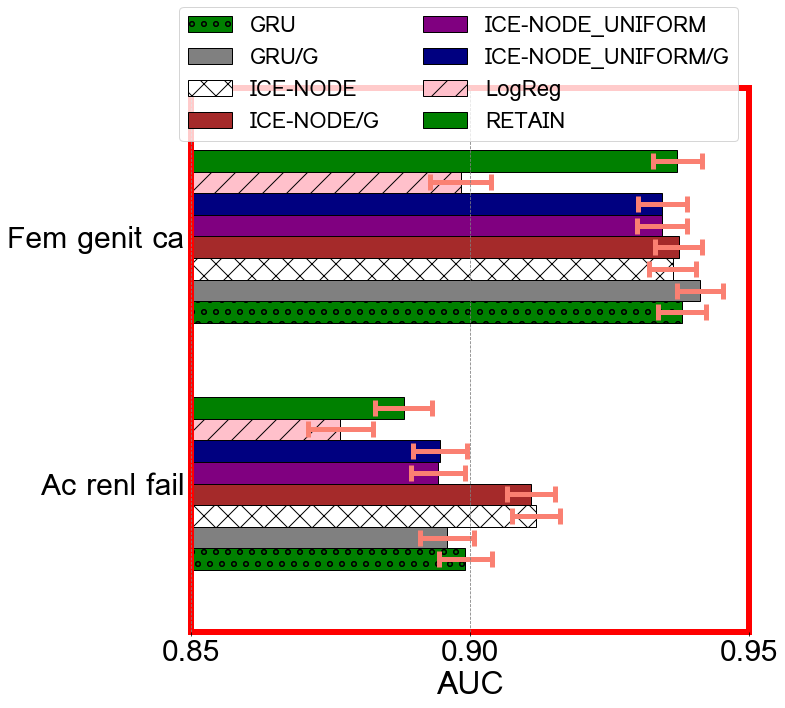

In [50]:
ax = A.selected_auc_barplot(upset_clfs, icenode_m4m3_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.legend(fontsize=22, title_fontsize=32,
#           bbox_to_anchor=(0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(1, 1.17), ncol=2)

current_figure = plt.gcf()
current_figure.savefig("icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [30]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [31]:
m4_icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)
m4_icenode_visit_auc_df['N_VISITS'] = m4_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())

In [32]:
m4_visit_auc_subject = m4_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min'] })

In [33]:
m4m3_icenode_visit_auc_df = admissions_auc_scores(m4m3_predictors['ICE-NODE'], m3_interface.subjects.keys())
m4m3_icenode_visit_auc_df['N_VISITS'] = m4m3_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4m3_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
m4m3_visit_auc_subject = m4m3_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min']
    })


In [34]:
m4_best_visit_auc_subjects =  m4_visit_auc_subject[(m4_visit_auc_subject.N_VISITS['max'] > 2) & (m4_visit_auc_subject.INTERVALS['max'] < 150)]
m4m3_best_visit_auc_subjects =  m4m3_visit_auc_subject[(m4m3_visit_auc_subject.N_VISITS['max'] > 1) & (m4m3_visit_auc_subject.INTERVALS['max'] < 150)]


In [35]:
len(m4_best_visit_auc_subjects), len(m4m3_best_visit_auc_subjects)

(365, 220)

In [38]:
m4_ccs_history = {i: m4_interface.dx_flatccs_history(i) for i in m4_best_visit_auc_subjects.index}
m4m3_ccs_history = {i: m3_interface.dx_flatccs_history(i) for i in m4m3_best_visit_auc_subjects.index}

m4_ccs_idx_frequency = m4_interface.dx_flatccs_frequency(list(m4_best_visit_auc_subjects.index))
m3_ccs_idx_frequency = m3_interface.dx_flatccs_frequency(list(m4m3_best_visit_auc_subjects.index))

In [39]:
m4_history_all_ccs_codes = set(map(flatccs_code2idx.get, set.union(*[set(h.keys()) for h in m4_ccs_history.values()])))
m3_history_all_ccs_codes = set(map(flatccs_code2idx.get, set.union(*[set(h.keys()) for h in m4m3_ccs_history.values()])))
m4_history_all_ccs_codes = {idx for idx in m4_history_all_ccs_codes if m4_ccs_idx_frequency[idx] < 10}
m3_history_all_ccs_codes = {idx for idx in m3_history_all_ccs_codes if m3_ccs_idx_frequency[idx] < 10}

len(m4_history_all_ccs_codes), len(m3_history_all_ccs_codes)

(51, 74)

In [44]:
icenode_m4_competent = upsetcontents_m4['ICE-NODE'] 
icenode_m4_competent = auctests_m4[auctests_m4['CODE_INDEX'].isin(icenode_m4_competent)]
icenode_m4_competent = icenode_m4_competent[['N_POSITIVE_CODES', 'AUC(ICE-NODE)', 'DESC']].sort_values('N_POSITIVE_CODES',ascending=False)
# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]
icenode_m4_competent[icenode_m4_competent.index.isin(trajectory_ccs_codes_level2)]

,N_POSITIVE_CODES,AUC(ICE-NODE),DESC
173,1790.0,0.941892,Non-Hodg lym
168,520.0,0.951321,Kidny/rnl ca
216,244.0,0.974325,Meningitis
169,181.0,0.942847,Uriny org ca
156,148.0,0.965231,Uterus cancr
165,146.0,0.957154,Testis cancr
171,89.0,0.940833,Thyroid cncr
100,84.0,0.952710,Brnch/lng ca
167,67.0,0.957488,Bladder cncr


In [45]:
trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
]


In [46]:
m4_ccs_history_level1 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}
m4m3_ccs_history_level1 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}

m4_ccs_history_level2 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}
m4m3_ccs_history_level2 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}

In [47]:
len(m4_ccs_history_level1), len(m4m3_ccs_history_level1), len(m4_ccs_history_level2), len(m4m3_ccs_history_level2) 


(180, 115, 68, 35)

In [48]:
m4_cases = set(m4_ccs_history_level1.keys()) | set(m4_ccs_history_level2.keys())
m4m3_cases = set(m4m3_ccs_history_level1.keys()) | set(m4m3_ccs_history_level2.keys())
len(m4_cases), len(m4m3_cases)

(206, 131)

In [53]:
m4_icenode, m4_icenode_state = m4_predictors['ICE-NODE']
m4_trajectory = m4_icenode.sample_trajectory(m4_icenode_state, m4_cases, 1)

  0%|                                                                                                                                                                         | 0/22 [00:00<?, ?it/s]/home/asem/GP/ICENODE/notebooks/../icenode/ehr_predictive/dx_icenode_tl.py:412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [20:14<00:00, 55.20s/it]


In [54]:
m4m3_icenode, m4m3_icenode_state = m4m3_predictors['ICE-NODE']
m4m3_trajectory = m4m3_icenode.sample_trajectory(m4m3_icenode_state, m4m3_cases, 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:46<00:00, 51.78s/it]


In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
# m4_selected_subjects = [
#     13798593, #acute-renal
#     13965528, #acute-renal
#     11907876, #pulmonary heart dx
#     13557547, #ear dx
#     10139504, #acute renal fail
#     12367864, #pulomonary-heart dx
# ]

# m4_selected_trajectory = {i: m4_trajectory[i] for i in m4_selected_subjects}

# m3_selected_subjects = [
#     50093 #pulmonary-heart dx
# ]

# m3_selected_trajectory = {i: m4m3_trajectory[i] for i in m3_selected_subjects}


In [81]:
import random

trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
    # Others
    100, # Brnch/lng ca
    168, # Kidney/rnl ca
    194, # Immunity dx
]



# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]

random.seed(42)
ccs_color = {
    6: 'blue',
    64: 'purple',
    236: 'orange',
    # Others
    100: 'salmon', # Brnch/lng ca
    168: 'navy', # Kidney/rnl ca
    194: 'pink', # Immunity dx
    **{idx: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                   for idx in trajectory_ccs_codes_level2}
}

In [101]:
interface = m4_interface
trajectories = m4_trajectory
level_label = "level2"
ccs_indexes = trajectory_ccs_codes_level2# + trajectory_ccs_codes_level2

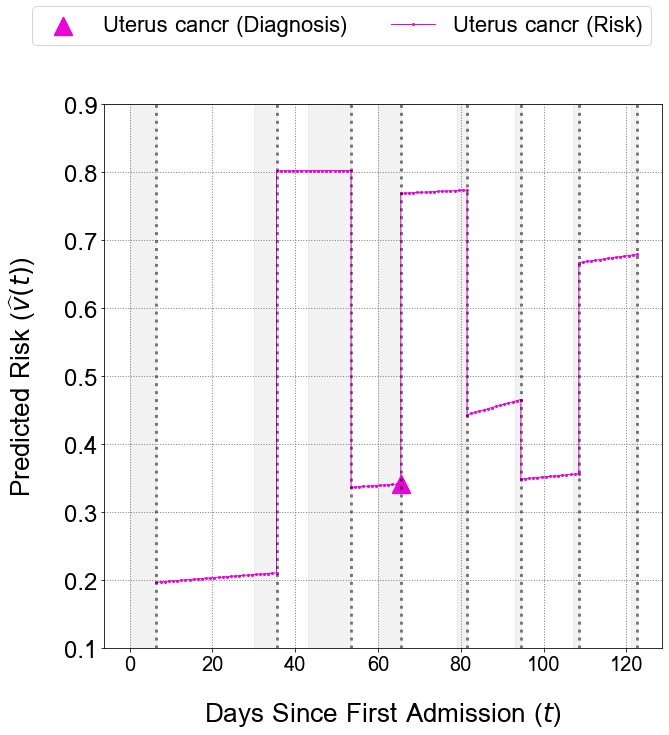

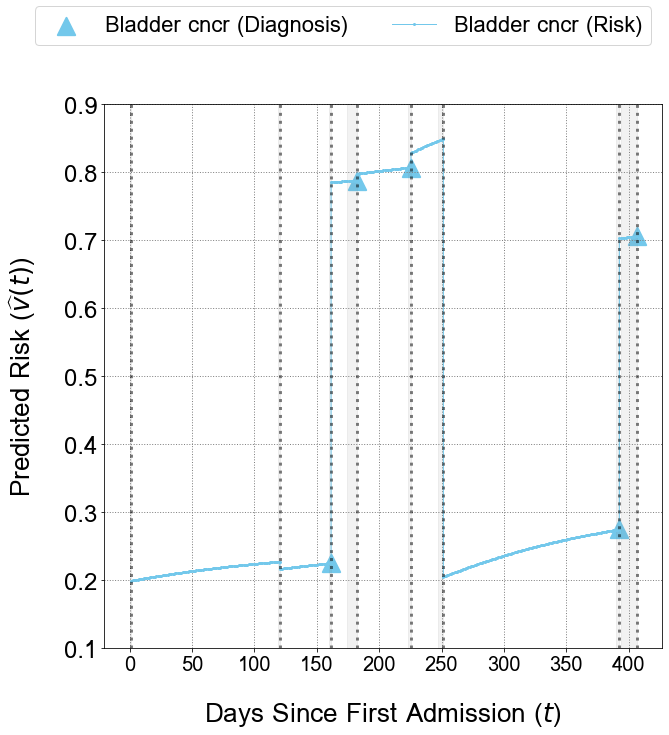

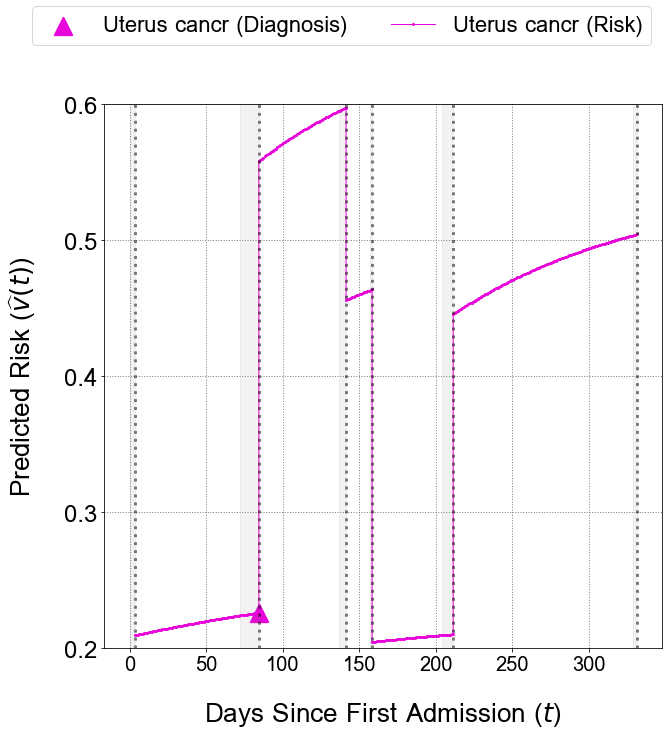

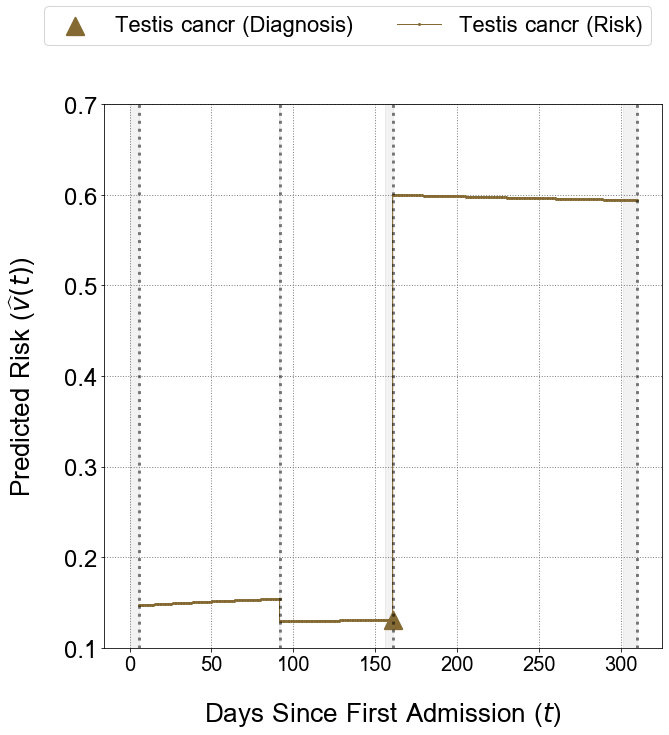

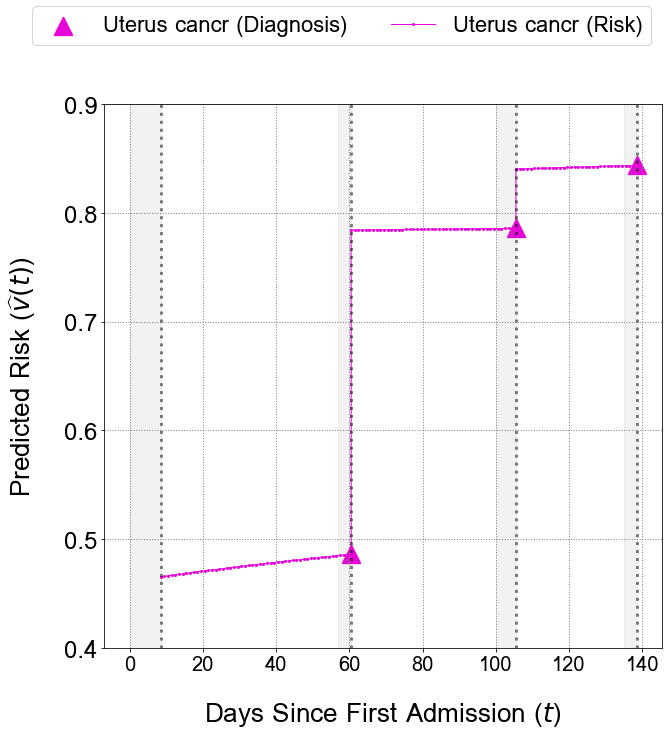

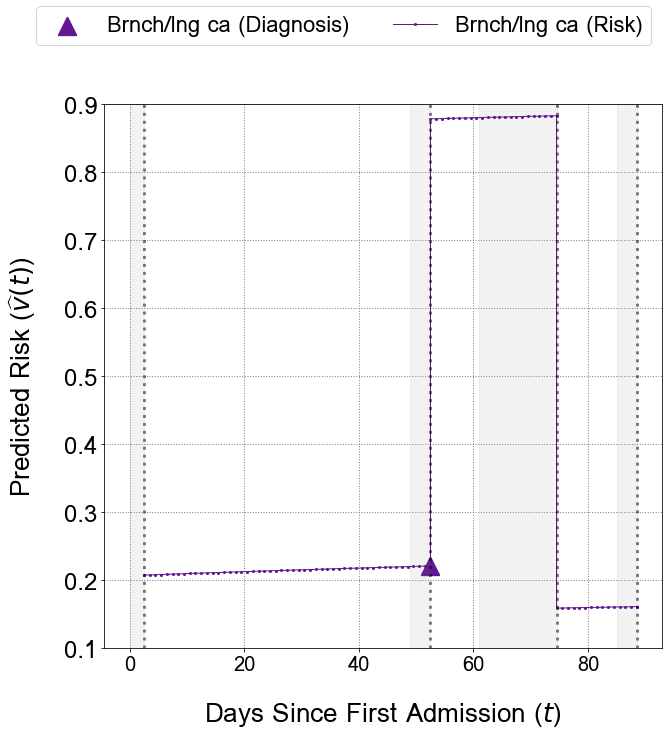

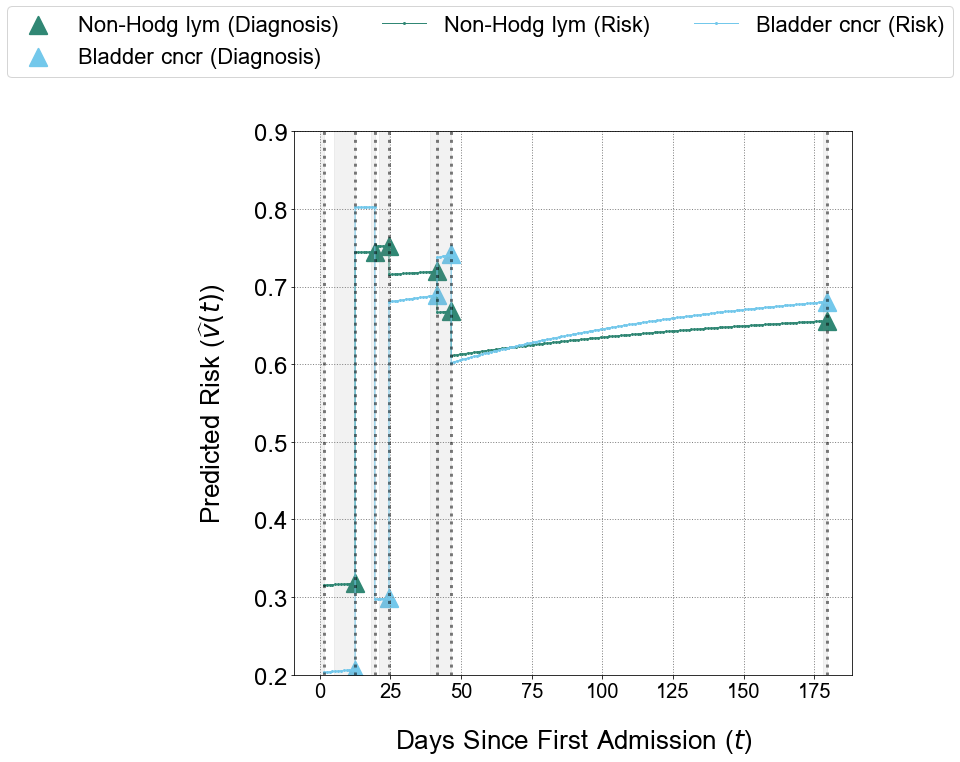

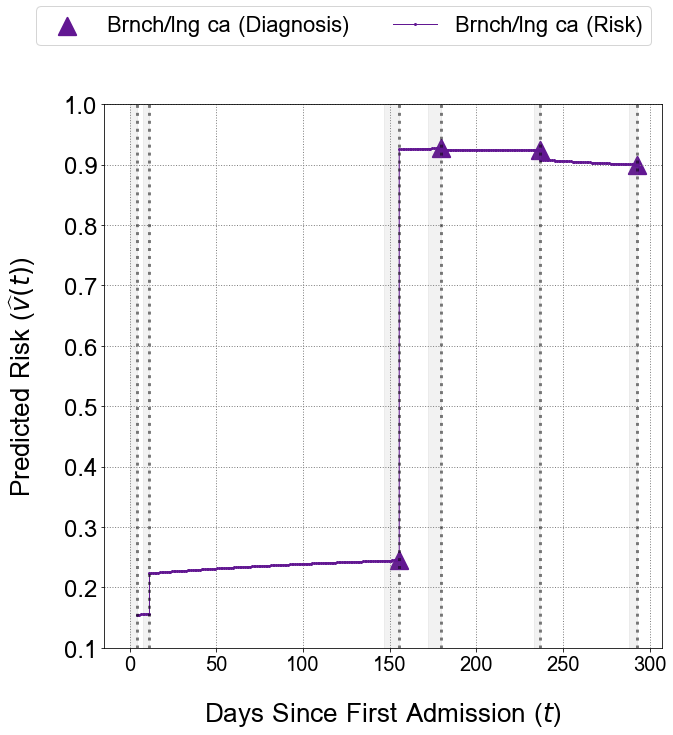

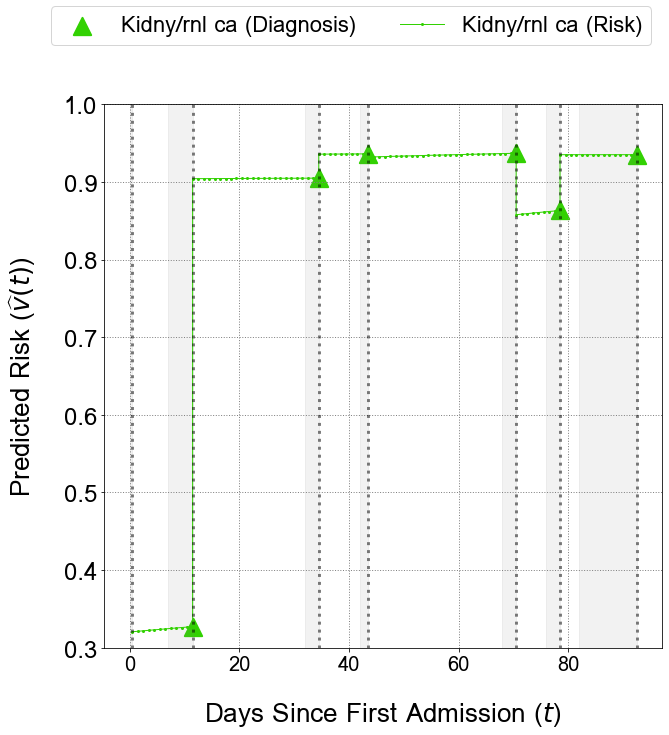

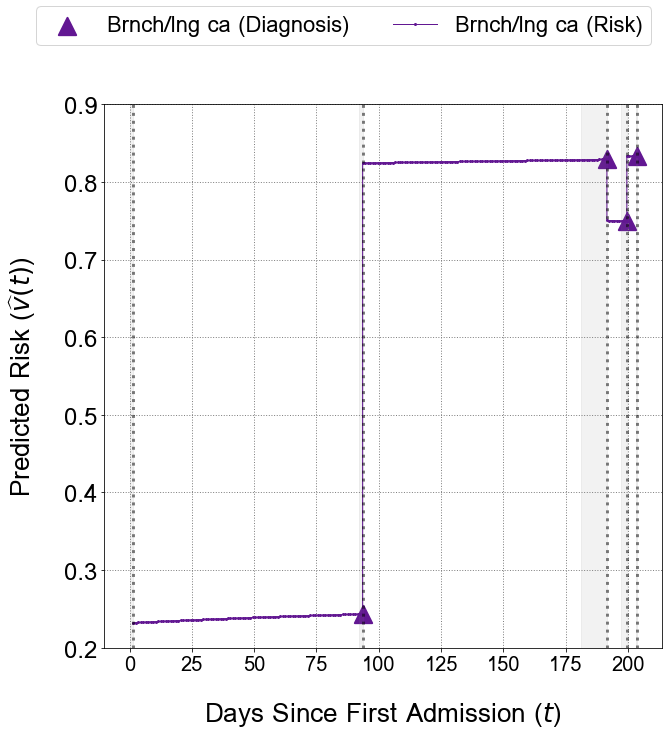

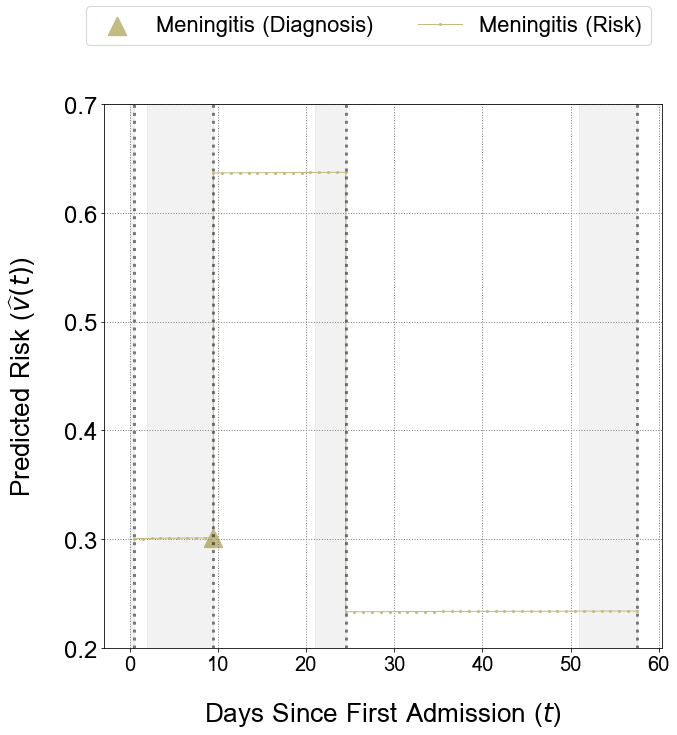

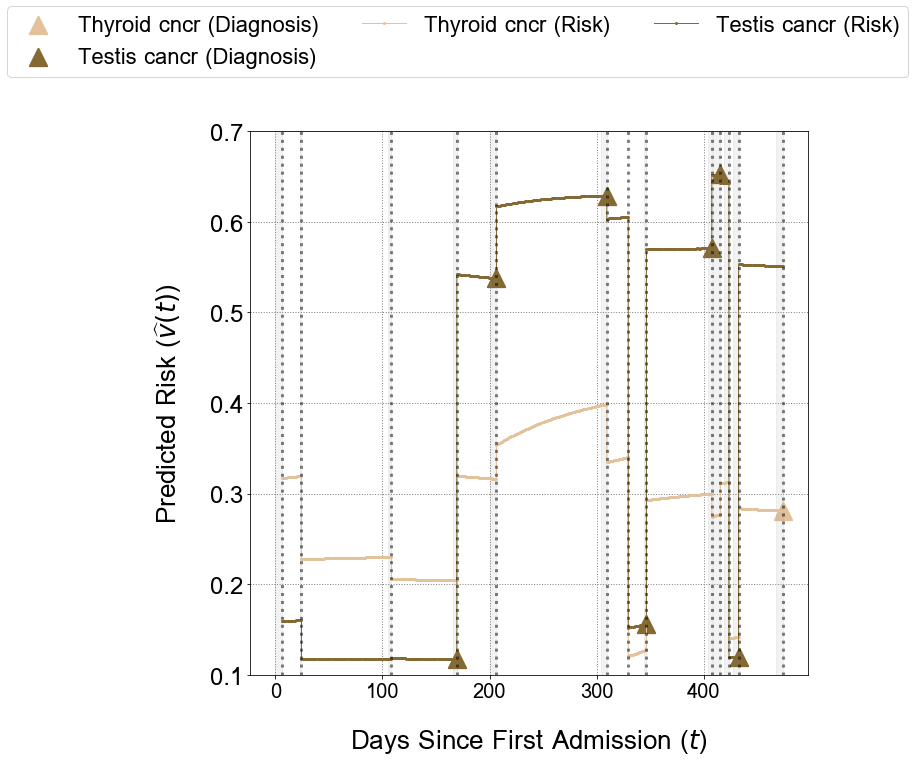

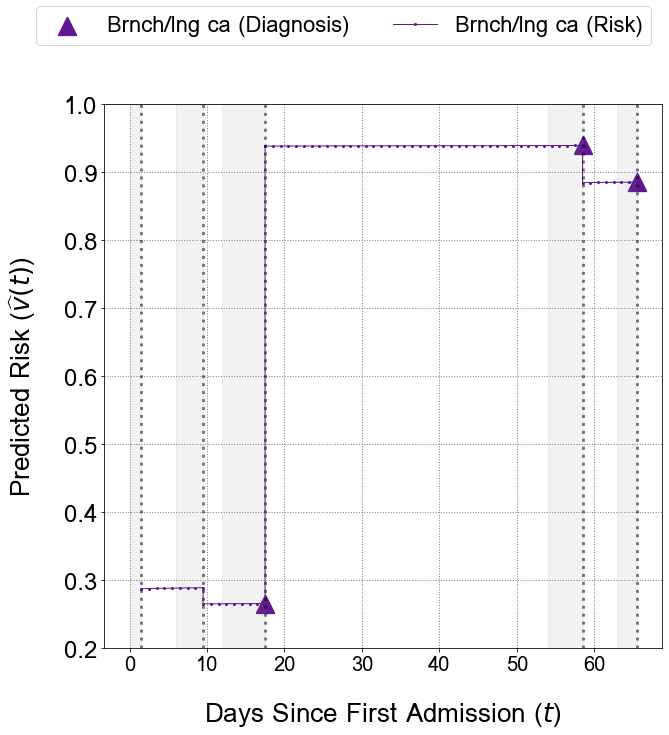

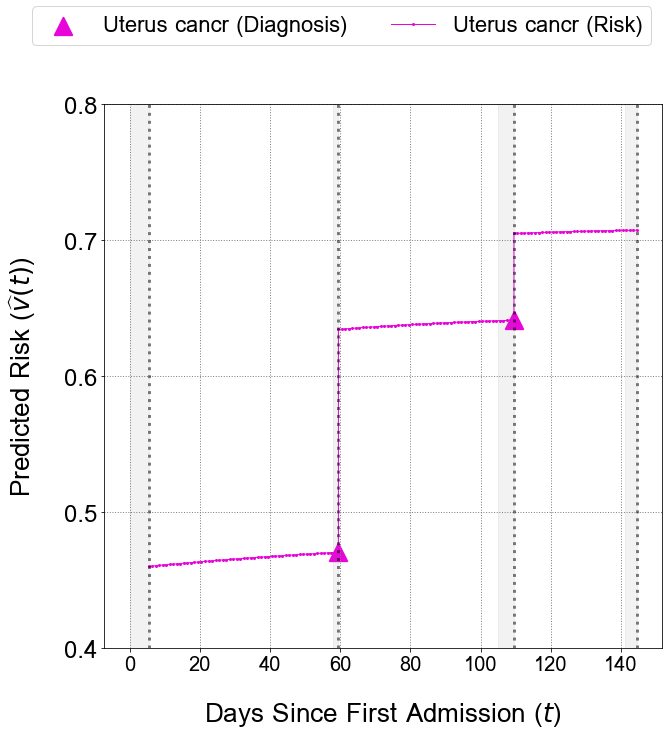

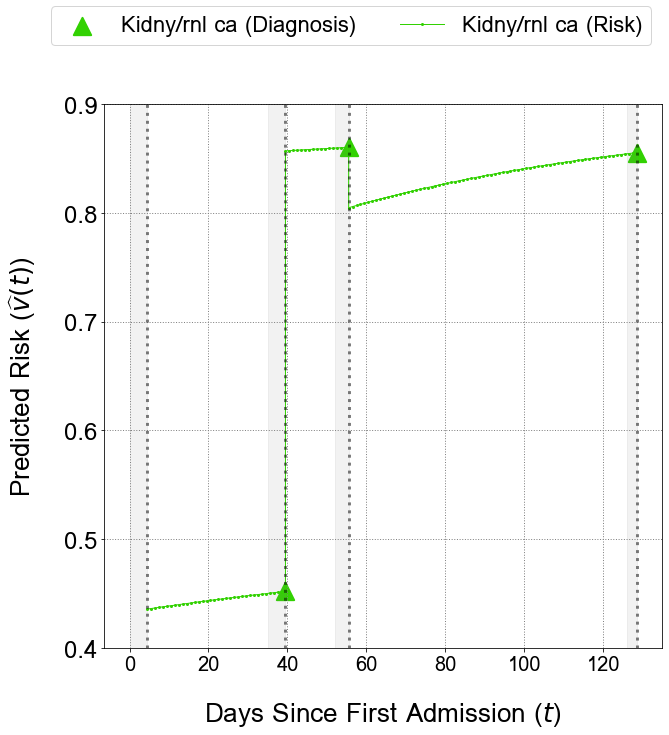

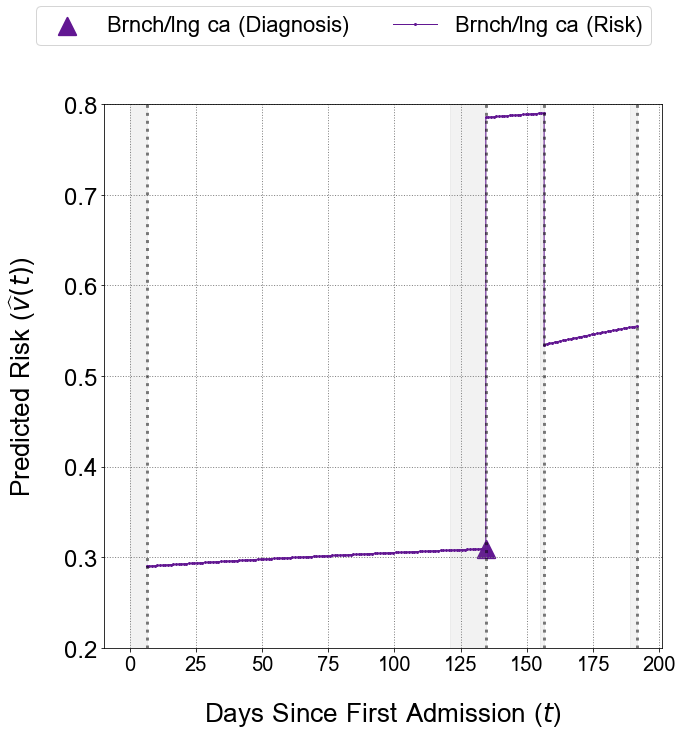

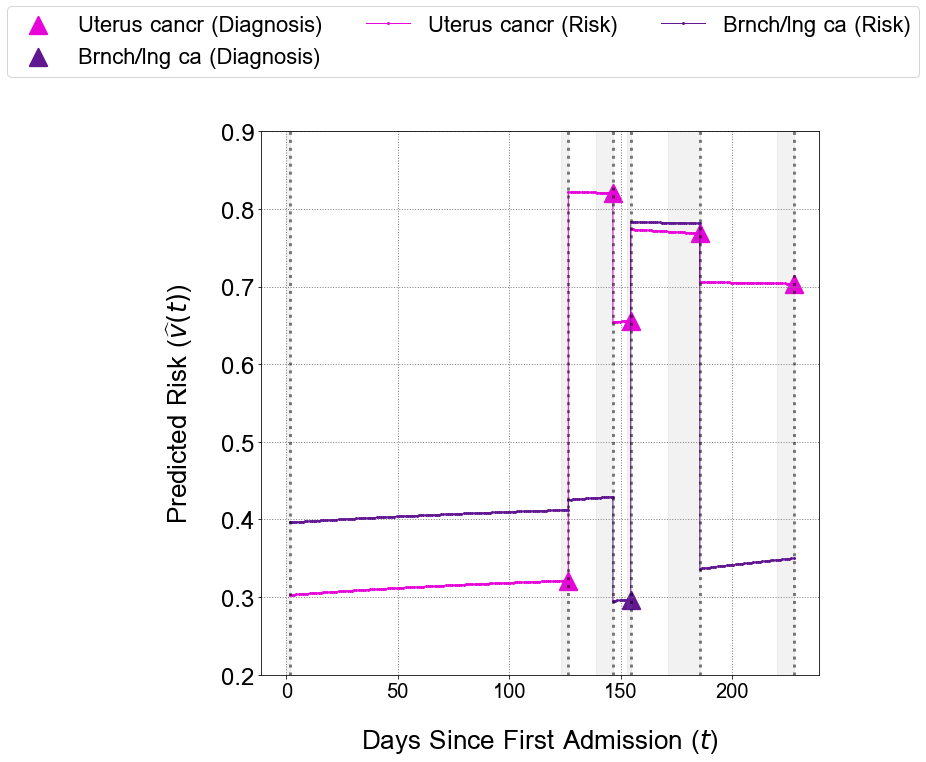

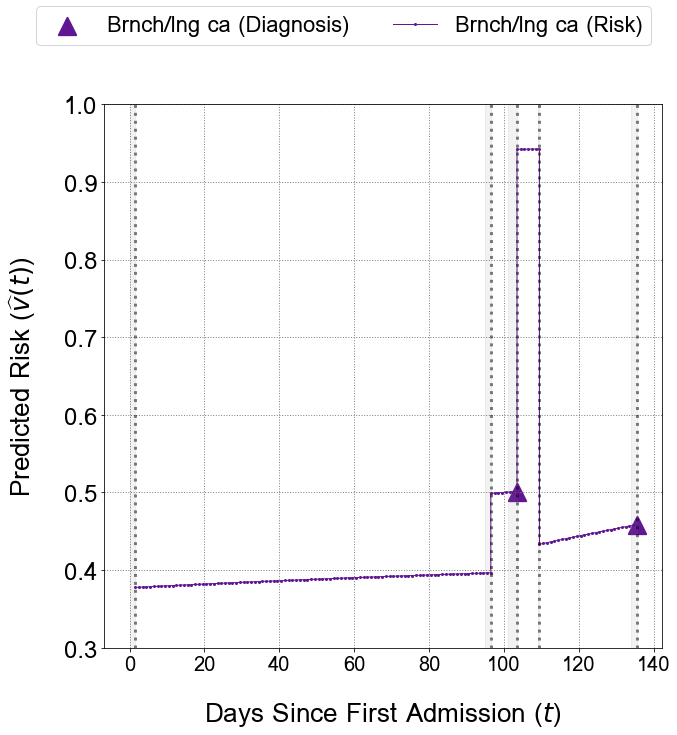

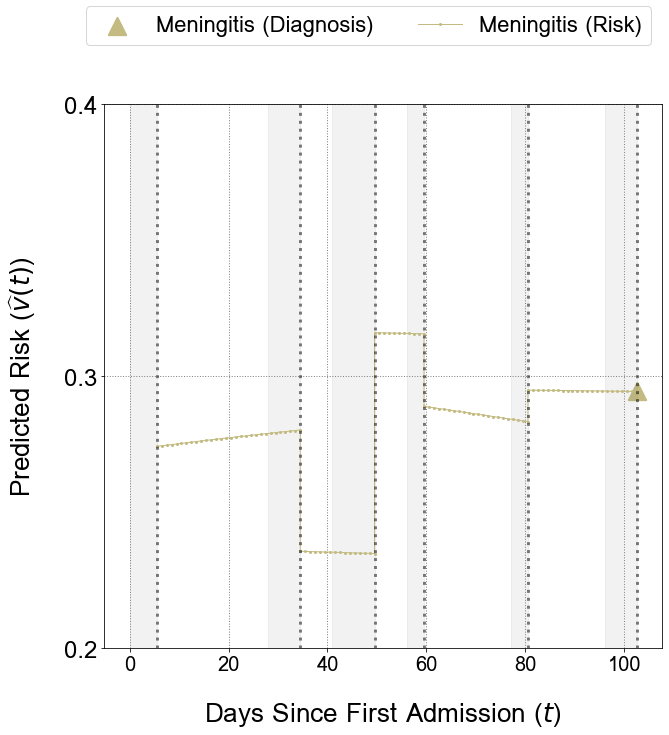

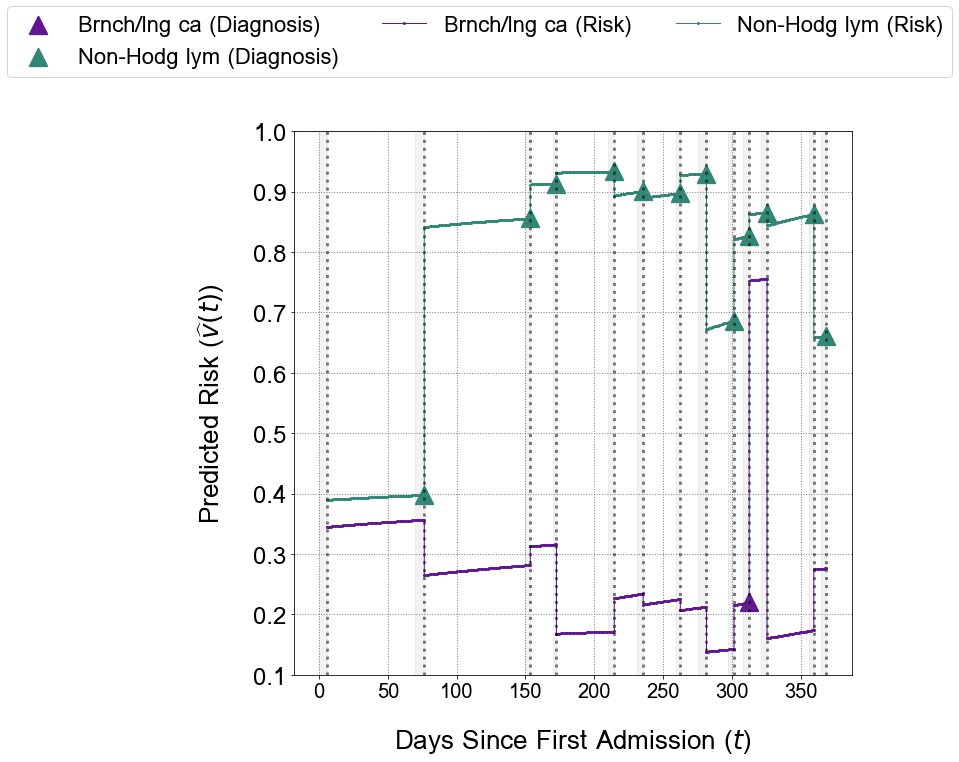

In [119]:
out_dir = f'{output_dir}/trajectories/M4_{level_label}' 
Path(out_dir).mkdir(parents=True, exist_ok=True)
A.plot_trajectory(trajectories=m4_trajectory, 
                  interface=m4_interface, 
                  flatccs_selection=ccs_indexes, 
                  ccs_color=ccs_color,
                  out_dir=out_dir)